## Mini-project 1
#### Hugo Yeche
### Import

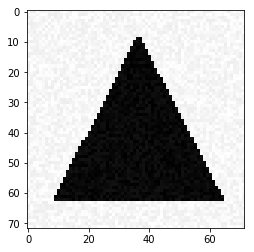

In [23]:
# %load mp1

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, UpSampling2D
from keras.optimizers import SGD, Adam

from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(nb_sample):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(nb_sample, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



### 3. Simple Classification

In [2]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:


In [50]:


#Class containing linear classifier
class simple_classifier():
    def _init_(self,model=None):
        self.model = model
    
    def train(self,X,Y,img_size,epochs = 100,batch_size=32,optimizer = SGD()):
        self.model = Sequential()
        self.model.add(Dense(3, activation='softmax',input_shape=(img_size*img_size,)))
        self.model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        labels = to_categorical(Y)
        return self.model.fit(X, labels, epochs=epochs, batch_size=32,verbose=0)
        
    def test(self,X,Y,batch_size=32):
        return self.model.evaluate(X,to_categorical(Y),batch_size=batch_size)

Here we test the model with train the model with two optimizer : SGD and Adam

In [51]:
classifier_adam = simple_classifier()
training_adam = classifier_adam.train(X_train,Y_train,IMAGE_SIZE,epochs=50,optimizer=Adam(lr=0.002))
classifier_SGD = simple_classifier()
training_SGD = classifier_SGD.train(X_train,Y_train,IMAGE_SIZE,epochs=50,optimizer=SGD(lr=0.001))

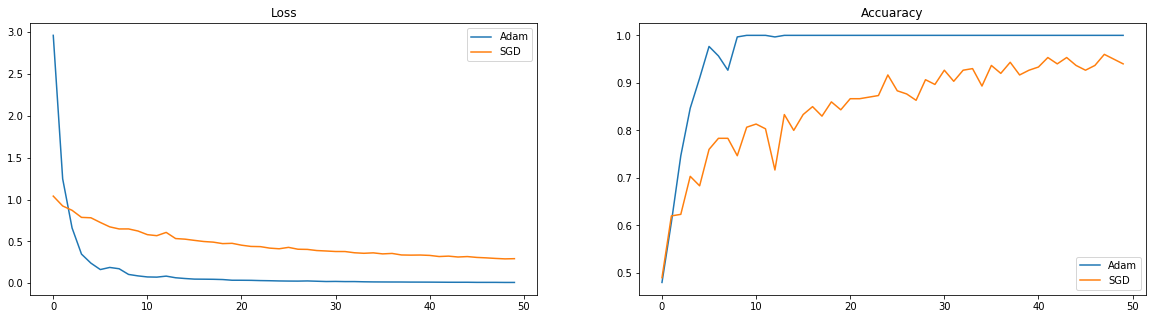

In [62]:
plt.figure(1,figsize=(20,5))
plt.subplot(121)
plt.plot(training_adam.history['loss'],label='Adam')
plt.plot(training_SGD.history['loss'],label='SGD')
plt.title('Loss')
plt.legend()
plt.subplot(122)
plt.plot(training_adam.history['acc'],label='Adam')
plt.plot(training_SGD.history['acc'],label='SGD')
plt.title('Accuaracy')
plt.legend()

In [54]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print('Adam prediction on circle',classifier_adam.model.predict(X_test))
print('SGD prediction on circle',classifier_SGD.model.predict(X_test))

Adam prediction on circle [[0. 1. 0.]]
SGD prediction on circle [[0. 1. 0.]]


Both model perform very efficiently for this task. Though we can see that Adam converges quicker than SGD.

 ### 4. Visualization of the Solution

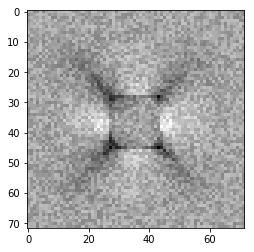

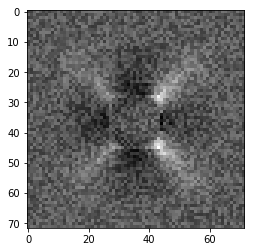

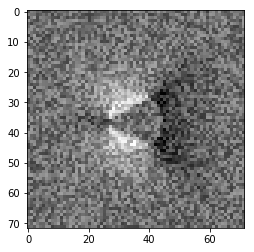

In [55]:
for k in np.array(classifier_adam.model.get_weights())[0].reshape(72,72,3).T:
    plt.imshow(k, cmap='gray') 
    plt.show()

We can see that each weight map correspond to a class, respectively square,circle,triangle. 

### 5. A More Difficult Classification Problem

In [57]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_test, Y_test] = generate_test_set_classification(300)

Creating data:
Creating data:


In [64]:
classifier_adam = simple_classifier()
training_move = classifier_adam.train(X_train,Y_train,IMAGE_SIZE,epochs=100,optimizer=Adam(lr=0.001))

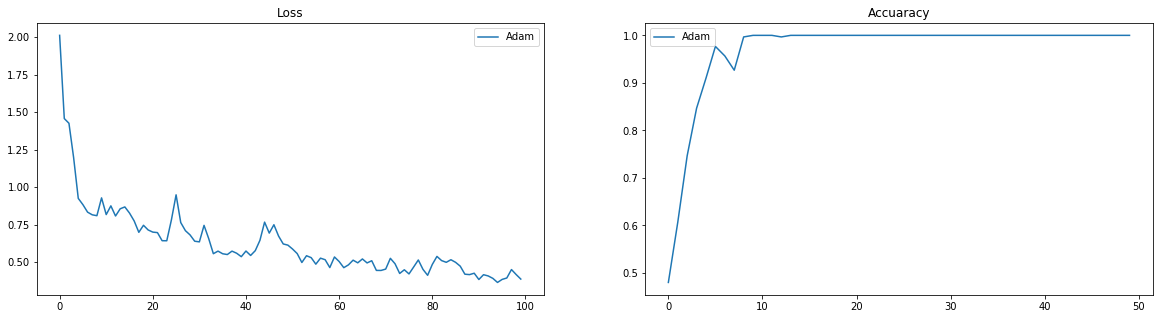

In [65]:
plt.figure(1,figsize=(20,5))
plt.subplot(121)
plt.plot(training_move.history['loss'],label='Adam')
plt.title('Loss')
plt.legend()
plt.subplot(122)
plt.plot(training_adam.history['acc'],label='Adam')
plt.title('Accuaracy')
plt.legend()

In [67]:
test_results = classifier_adam.model.evaluate(X_test,Y_test)
print('Loss in test' ,test_results[0],'Acc in test', test_results[1])

300/300 [==============================] - 0s 915us/step
Loss in test 0.9486410729090373 Acc in test 0.58


Here we observe how the model overfit in training. Indeed it learns by heart the labels on training set but performs poorly in  testing because it's a too simple model compared to the classification problem. Therefore we do a more complicated classifier based on convolutional layers as follows

In [77]:
class cnn_classifier():
    def _init_(self,model=None):
        self.model = model
        self.im_size = None
    
    def train(self,X,Y,img_size=72,epochs = 100,optimizer = SGD()):
        self.im_size = img_size
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(5,5), activation='relu',input_shape=(img_size,img_size,1)))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Flatten())
        self.model.add(Dense(3,activation='softmax'))
        self.model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        labels = to_categorical(Y)
        print(labels.shape)
        data = X.reshape((X.shape[0],img_size,img_size,1))
        return self.model.fit(data, labels, epochs=epochs, batch_size=32,verbose=0)
        
    def test(self,X,labels,batch_size=32):
        img_size=self.im_size
        data = X.reshape((X.shape[0],img_size,img_size,1))
        return self.model.evaluate(data,labels,batch_size=batch_size)

In [75]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
[X_test, Y_test] = generate_test_set_classification(300)

Creating data:
Creating data:


In [78]:
cnn_adam = cnn_classifier()
training_cnn_1 = cnn_adam.train(X_train,Y_train,IMAGE_SIZE,epochs=50,optimizer='adadelta')

(1000, 3)


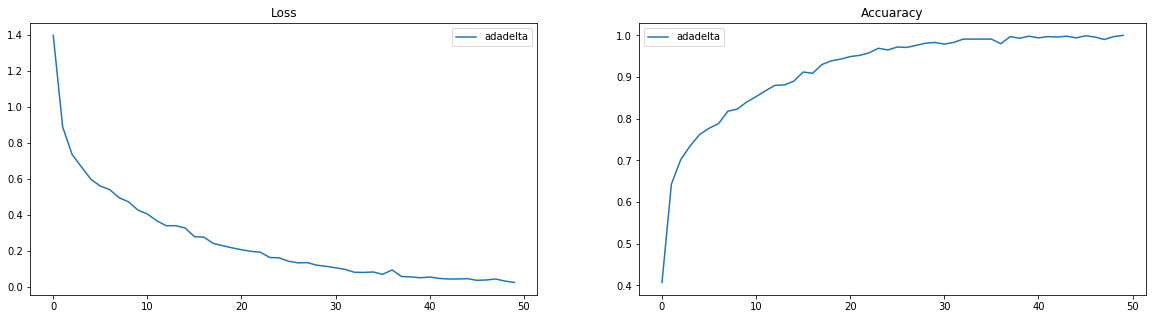

In [80]:
plt.figure(1,figsize=(20,5))
plt.subplot(121)
plt.plot(training_cnn_1.history['loss'],label='adadelta')
plt.title('Loss')
plt.legend()
plt.subplot(122)
plt.plot(training_cnn_1.history['acc'],label='adadelta')
plt.title('Accuaracy')
plt.legend()

In [81]:

test_results = cnn_adam.test(X_test,Y_test)
print('Loss in test' ,test_results[0],'Acc in test', test_results[1])

300/300 [==============================] - 1s 2ms/step
Loss in test 0.6415500505765279 Acc in test 0.7933333333333333


We have better performance with the suggested CNN but there is some overfitting. Some dropout could help

### 6. A Regression Problem

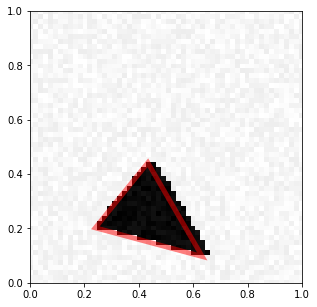

In [24]:
[X_train, Y_train] = generate_dataset_regression(2000, 20)
[X_test, Y_test] = generate_test_set_regression()
visualize_prediction(X_train[0], Y_train[0])

In [25]:
class regressor():
    def _init_(self,model=None):
        self.model = model
        self.im_size = None
    
    def train(self,X,Y,img_size=72,epochs = 100,optimizer ='adadelta'):
        self.im_size = img_size
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(img_size,img_size,1)))
        self.model.add(Dropout(0.05))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
        self.model.add(Dropout(0.05))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
        self.model.add(Dropout(0.05))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
        self.model.add(Dropout(0.05))
        self.model.add(Flatten())
        self.model.add(Dense(128,activation='relu'))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(6))
        self.model.compile(optimizer=optimizer,
              loss='mse',
              )
        print(self.model.summary())
        labels = np.array(Y).reshape((Y.shape[0],3,2))
        for t in range(len(labels)):
            my_list = sorted(labels[t] , key=lambda k: [1-k[0],1-k[1]])
            Y[t]=np.array(my_list).reshape(6)
        data = X.reshape((X.shape[0],img_size,img_size,1))
        return self.model.fit(data, Y, epochs=epochs, batch_size=32,verbose = 0)
        
    def test(self,X,Y,batch_size=32):
        img_size=self.im_size
        labels = np.array(Y).reshape((Y.shape[0],3,2))
        for t in range(len(labels)):
            my_list = sorted(labels[t] , key=lambda k: [1-k[0],1-k[1]])
            Y[t]=np.array(my_list).reshape(6)
        data = X.reshape((X.shape[0],img_size,img_size,1))
        return self.model.evaluate(data,Y,batch_size=batch_size)

In [26]:
reg=regressor()
train_reg = reg.train(X_train,Y_train,epochs=150,img_size=72,optimizer='adadelta')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 70, 70, 16)        160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 70, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 33, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 64)        18496     
__________

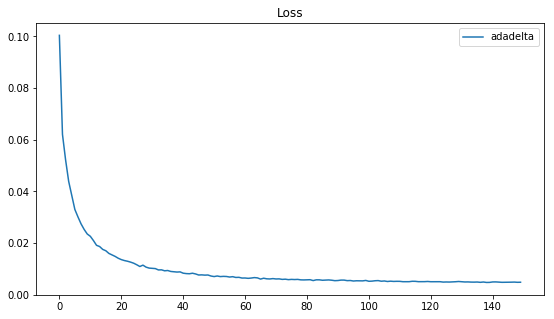

In [27]:
plt.figure(1,figsize=(20,5))
plt.subplot(121)
plt.plot(train_reg.history['loss'],label='adadelta')
plt.title('Loss')
plt.legend()


In [28]:
print('Loss in training', reg.test(X_test,Y_test))

300/300 [==============================] - 1s 2ms/step
Loss in training 0.005683578463892142


In [30]:
pred = reg.model.predict(X_test.reshape((X_test.shape[0],72,72,1)))


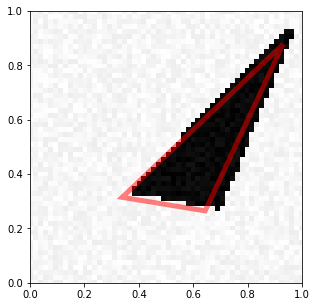

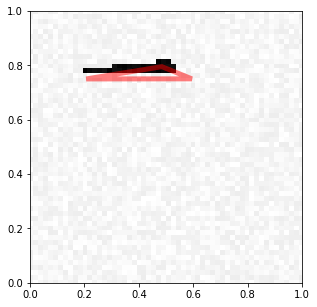

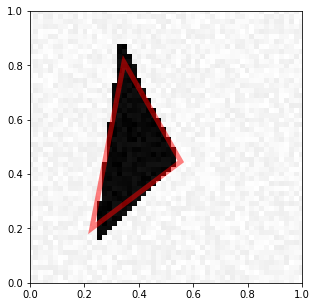

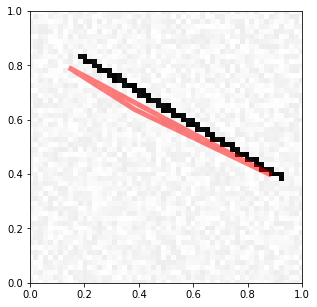

In [34]:
for k in range(4):
    visualize_prediction(X_test[k], pred[k])

As expected we have quite good performance on triangles wide enough but the networks performs poorly on flat ones.

### 7. Image Denoising

In [11]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imclean = np.array(imdata)
    amp = np.random.randint(1,10)*10
    imdata = imdata + amp*np.random.random(imdata.size)
    plt.close(fig)
    return imdata ,imclean

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return imdata

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [12]:
[X_train, Y_train] = generate_dataset_regression(2000, 50)

Creating data:


Below is an example of the input image 

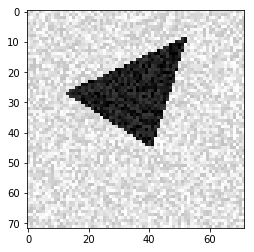

In [16]:
plt.imshow(X_train[1].reshape(72,72),cmap='gray')

In [17]:
class hourglass():
    def _init_(self,model=None):
        self.model = model
        self.im_size = None
    
    def train(self,X,Y,img_size=72,epochs = 100,optimizer ='adadelta'):
        self.im_size = img_size
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3,3),padding = 'same', activation='relu',input_shape=(img_size,img_size,1)))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(32, kernel_size=(3,3),padding = 'same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(64, kernel_size=(3,3), padding = 'same',activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(128, kernel_size=(3,3), padding = 'same',activation='relu'))
        self.model.add(Conv2D(64, kernel_size=(3,3), padding = 'same',activation='relu'))
        self.model.add(UpSampling2D(interpolation='bilinear'))
        self.model.add(Conv2D(32, kernel_size=(3,3),padding = 'same', activation='relu'))
        self.model.add(UpSampling2D(interpolation='bilinear'))
        self.model.add(Conv2D(16, kernel_size=(3,3),padding = 'same', activation='relu'))
        self.model.add(UpSampling2D(interpolation='nearest'))
        self.model.add(Conv2D(1, kernel_size=(3,3),padding = 'same', activation='relu'))
        self.model.compile(optimizer=optimizer,
              loss='mse',
              )
        print(self.model.summary())
        labels = Y.reshape((Y.shape[0],img_size,img_size,1))/255
        data = X.reshape((X.shape[0],img_size,img_size,1))
        return self.model.fit(data, labels, epochs=epochs, batch_size=32,verbose = 0)
        
    def test(self,X,Y,batch_size=32):
        img_size=self.im_size
        labels = Y.reshape((Y.shape[0],img_size,img_size,1))
        data = X.reshape((X.shape[0],img_size,img_size,1))
        return self.model.evaluate(data,labels,batch_size=batch_size)

In [18]:
hour=hourglass()
train_hour = hour.train(X_train,Y_train,epochs=100,img_size=72,optimizer='adadelta')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 72, 72, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 36, 36, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 128)         73856     
__________

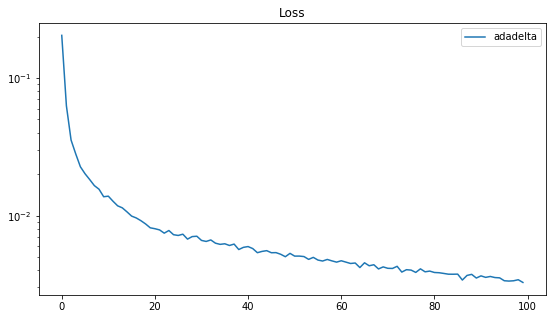

In [21]:
plt.figure(1,figsize=(20,5))
plt.subplot(121)
plt.plot(train_hour.history['loss'],label='adadelta')
plt.yscale('log')
plt.title('Loss')
plt.legend()


In [19]:
[X_test, Y_test] = generate_dataset_regression(100, 30)

Creating data:


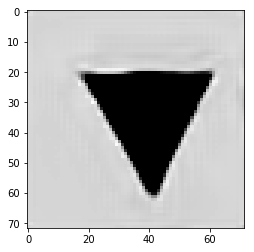

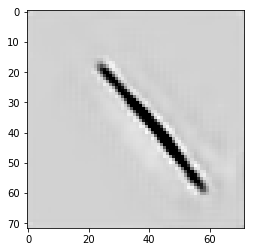

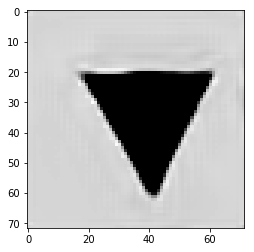

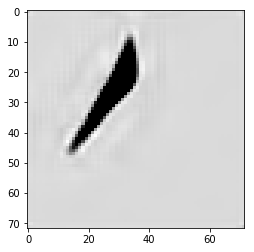

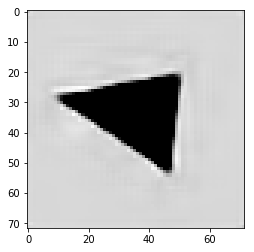

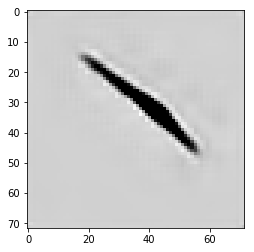

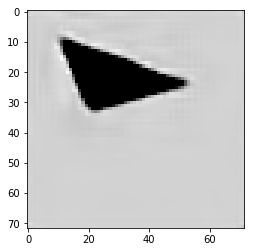

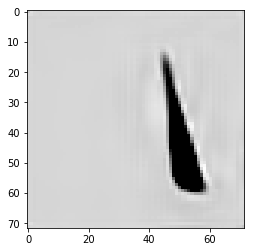

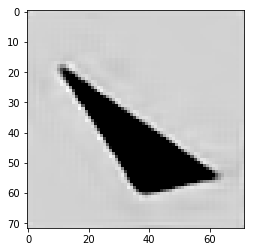

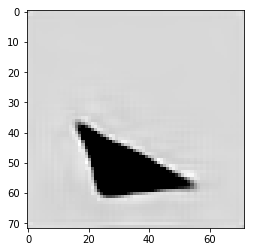

In [22]:
pred = hour.model.predict(X_test.reshape((X_test.shape[0],72,72,1)))
for k in range(10):
    p = np.random.randint(len(pred))
    plt.imshow(pred[p].reshape(72,72)*255,cmap='gray')
    plt.show()

We have somme satisfying results for large triangles. Though for smaller ones and concerning the edges we have some residual noise due to interpolation technique. after experimenting , I found that at early layers bilinear was preferable over nearest neighbor.
